## SRJ - Measurement counts

In [5]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from itertools import chain
import time
import re
from scipy.optimize import minimize
ash_excitation = []
energies = []
excitations= []

X = qml.PauliX
Y = qml.PauliY
Z = qml.PauliZ
I = qml.Identity



bond_length = 3.0
symbols = ["H","H","H","H"]
electrons = 4
orbitals = 8
r_bohr = bond_length *1.8897259886  
coordinates = np.array([[0.0,0.0, 1*r_bohr], [0.0, 0.0, 2*r_bohr], [0.0,0.0,3*r_bohr],[0.0, 0.0, 4*r_bohr]])
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-6g", method="pyscf")
hf_state = qchem.hf_state(electrons, qubits)




def adaptvqe(adapt_it = 4, e_th=1e-12):
    ash_excitation = []
    energies = []
    excitations= []
    #Calculation of HF state
    dev = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev)
    def circuit(hf_state, electrons, qubits, H):
        print('Updated hf_state is', hf_state)  
        qml.BasisState(hf_state, wires=range(qubits))
        return qml.expval(H)   #Calculating the expectation value of the Hamiltonian
    
    # Commutator calculation for HF state
    @qml.qnode(dev)
    def commutator_0(H,w, k):  #H is the Hamiltonian, w is the operator, k is the basis state - HF state
        qml.BasisState(k, wires=range(qubits))
        res = qml.commutator(H, w)   #Calculating the commutator
        return qml.expval(res)
    
    # Commutator calculation for other states except HF state
    @qml.qnode(dev)
    def commutator_1(H,w, k): #H is the Hamiltonian, w is the operator, k is the basis state
        qml.StatePrep(k, wires=range(qubits))
        res = qml.commutator(H, w) #Calculating the commutator
        return qml.expval(res)

    #Energy calculation 
    @qml.qnode(dev)
    def ash(params, ash_excitation, hf_state, H):
        [qml.PauliX(i) for i in np.nonzero(hf_state)[0]]  #Appln of HF state
        for i, excitation in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.expval(H)  #Calculating the expectation value of the Hamiltonian
    
    # Calculation of New state, same as the above function but with the state return
    dev1 = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev1)
    def new_state(hf_state, ash_excitation, params):
        [qml.PauliX(i) for i in np.nonzero(hf_state)[0]] #Applying the HF state
        for i, excitations in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.state()
    
    def cost(params):
        energy = ash(params, ash_excitation, hf_state, H)
        return energy

    def callback(params):
        print(f"Current parameters: {params}")
        print(f"Current cost: {cost(params)}\n")
    

    print('HF state is', circuit(hf_state, electrons, qubits, H))
    singles, doubles = qml.qchem.excitations(electrons, orbitals)
    op1 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "-"}) for x in singles]
    op2 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "+", (2, x[2]): "-", (3, x[3]): "-"})for x in doubles]
    operator_pool = (op1) + (op2)  #Operator pool - Singles and Doubles
    states = [hf_state]
    

    for j in range(adapt_it):
        print('The adapt iteration now is', j)  #Adapt iteration
        max_value = float('-inf')
        max_operator = None
        k = states[-1] if states else hf_state  # if states is empty, fall back to hf_state
       
        for i in operator_pool:
            w = qml.fermi.jordan_wigner(i)  #JW transformation
            if np.array_equal(k, hf_state): # If the current state is the HF state
                current_value = abs(2*(commutator_0(H, w, k)))      #Commutator calculation is activated  
            else:
                current_value = abs(2*(commutator_1(H, w, k)))      #For other states, commutator calculation is activated
            #print(f'The expectation value of {i} is', current_value)

            if current_value > max_value:
                max_value = current_value
                max_operator = i

        #print(f"The highest operator value is {max_value} for operator {max_operator}")  #Highest operator value

        # Convert operator to excitations and append to ash_excitation
        indices_str = re.findall(r'\d+', str(max_operator))
        excitations = [int(index) for index in indices_str]
        print('Highest gradient excitation is', excitations)
        ash_excitation.append(excitations) #Appending the excitations to the ash_excitation
        if j == 0:
            params = qml.numpy.zeros(len(ash_excitation), requires_grad=True)  #Parameters initialization
            #print('Parameters are', params)
        else:
            params = np.append(params, 0.0) 
            #print('Parameters before optimization are', params)


        #Energy calculation
        result = minimize(cost, params, method='powell', callback=callback, tol = e_th, options = {'disp': True, 'maxiter': 1e8, 'xtol':1e-8, 'ftol':1e-8})

        #print("Final updated parameters:", result.x)
        #print("Final cost:", result.fun)

        params= (result.x)
        energies.append(result.fun)
        print('Updated params are', params)
        print('Updated excitation are', ash_excitation)

        # New state generation - With the updated parameters
        ostate = new_state(hf_state, ash_excitation, params)
        print(qml.draw(new_state, max_length=100)(hf_state,ash_excitation,params))
        gs_state = ostate
        # Append the new state to the states list
        states.append(ostate)

    return energies, params, ash_excitation, gs_state, H, qubits, states


In [6]:
energies, params, ash_excitation, gs_state,H, qubits, states = adaptvqe(adapt_it = 5, e_th=1e-12)
print('Energies:', energies)

Updated hf_state is [1 1 1 1 0 0 0 0]
HF state is -1.3325688880668924
The adapt iteration now is 0


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

Highest gradient excitation is [2, 3, 6, 7]
Current parameters: [-1.12299269]
Current cost: -1.430083670840338

Current parameters: [-1.1229927]
Current cost: -1.430083670840339

Optimization terminated successfully.
         Current function value: -1.430084
         Iterations: 2
         Function evaluations: 42
Updated params are [-1.1229927]
Updated excitation are [[2, 3, 6, 7]]
0: ──X───────────────────────────────────┤  State
1: ──X───────────────────────────────────┤  State
2: ──X─╭FermionicDoubleExcitation(-1.12)─┤  State
3: ──X─├FermionicDoubleExcitation(-1.12)─┤  State
6: ────├FermionicDoubleExcitation(-1.12)─┤  State
7: ────╰FermionicDoubleExcitation(-1.12)─┤  State
The adapt iteration now is 1


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

Highest gradient excitation is [0, 3, 5, 6]
Current parameters: [-1.12299272 -1.38120328]
Current cost: -1.5693729293494711

Current parameters: [-1.09743877 -1.37779479]
Current cost: -1.5694603735017671

Current parameters: [-1.09716184 -1.37775784]
Current cost: -1.5694603835520686

Optimization terminated successfully.
         Current function value: -1.569460
         Iterations: 3
         Function evaluations: 193
Updated params are [-1.09716184 -1.37775784]
Updated excitation are [[2, 3, 6, 7], [0, 3, 5, 6]]
0: ──X───────────────────────────────────╭FermionicDoubleExcitation(-1.38)─┤  State
1: ──X───────────────────────────────────│─────────────────────────────────┤  State
2: ──X─╭FermionicDoubleExcitation(-1.10)─│─────────────────────────────────┤  State
3: ──X─├FermionicDoubleExcitation(-1.10)─├FermionicDoubleExcitation(-1.38)─┤  State
5: ────│─────────────────────────────────├FermionicDoubleExcitation(-1.38)─┤  State
6: ────├FermionicDoubleExcitation(-1.10)─╰FermionicDouble

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

Highest gradient excitation is [0, 1, 4, 5]
Current parameters: [-1.09716184 -1.37775784 -1.44489272]
Current cost: -1.7420659508469365

Current parameters: [-1.2016524  -1.38132946 -1.45784155]
Current cost: -1.7436329052703188

Current parameters: [-1.20338931 -1.38266312 -1.45806208]
Current cost: -1.7436334410234648

Current parameters: [-1.20339347 -1.38269592 -1.45818893]
Current cost: -1.7436334426139133

Optimization terminated successfully.
         Current function value: -1.743633
         Iterations: 4
         Function evaluations: 303
Updated params are [-1.20339347 -1.38269592 -1.45818893]
Updated excitation are [[2, 3, 6, 7], [0, 3, 5, 6], [0, 1, 4, 5]]
0: ──X───────────────────────────────────╭FermionicDoubleExcitation(-1.38)
1: ──X───────────────────────────────────│────────────────────────────────
2: ──X─╭FermionicDoubleExcitation(-1.20)─│────────────────────────────────
3: ──X─├FermionicDoubleExcitation(-1.20)─├FermionicDoubleExcitation(-1.38)
4: ────│──────────────

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

Highest gradient excitation is [1, 2, 4, 7]
Current parameters: [-1.20339326 -1.38269649 -1.45819229 -0.74667127]
Current cost: -1.7950366169143308

Current parameters: [-0.87368098 -1.35355146 -1.12296865 -1.10548115]
Current cost: -1.8396519146932977

Current parameters: [-0.82174612 -1.29738943 -1.02657854 -1.16076054]
Current cost: -1.8420601939441343

Current parameters: [-0.82588732 -1.28904    -1.01004782 -1.16435762]
Current cost: -1.8421083825253566

Current parameters: [-0.82832153 -1.28819003 -1.0081335  -1.16401004]
Current cost: -1.8421101067126222

Current parameters: [-0.82877638 -1.28812861 -1.00804507 -1.16386036]
Current cost: -1.8421101508893458

Current parameters: [-0.8288215  -1.28813041 -1.00807027 -1.16384551]
Current cost: -1.8421101514225207

Optimization terminated successfully.
         Current function value: -1.842110
         Iterations: 7
         Function evaluations: 595
Updated params are [-0.8288215  -1.28813041 -1.00807027 -1.16384551]
Updated excit

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

Highest gradient excitation is [1, 5]
Current parameters: [-0.82881995 -1.28813218 -1.0080711  -1.16383501  0.28091908]
Current cost: -1.8504266080062828

Current parameters: [-0.83224736 -1.2890789  -1.01501106 -1.1648295   0.28113536]
Current cost: -1.8504351644187969

Current parameters: [-0.8303699  -1.2892529  -1.01550549 -1.16541001  0.28113536]
Current cost: -1.85043592391412

Current parameters: [-0.8301377  -1.28924897 -1.01542177 -1.16552836  0.28113536]
Current cost: -1.8504359362884808

Optimization terminated successfully.
         Current function value: -1.850436
         Iterations: 4
         Function evaluations: 519
Updated params are [-0.8301377  -1.28924897 -1.01542177 -1.16552836  0.28113536]
Updated excitation are [[2, 3, 6, 7], [0, 3, 5, 6], [0, 1, 4, 5], [1, 2, 4, 7], [1, 5]]
0: ──X───────────────────────────────────╭FermionicDoubleExcitation(-1.29)
1: ──X───────────────────────────────────│────────────────────────────────
2: ──X─╭FermionicDoubleExcitation(-0.8

In [7]:
import pennylane as qml

# Initialize device with 1000 shots
dev4 = qml.device("lightning.qubit", wires=qubits, shots=1000)

@qml.qnode(dev4)
def measurement(gs_state):
    qml.StatePrep(gs_state, wires=range(qubits))
    return qml.counts(all_outcomes = False)  # Samples all qubits

counts = measurement(gs_state)
print(counts)
#Highest probability state : |11110000>
#1 Adapt : HF state
#2 Adapt : |11110000> state
#3 Adapt : |01100110>
#4 Adapt : |11110000> - 2808
#5 Adapt : |11110000> - 2781
#7 Adapt : |11110000> - 1949

# 10 Adapt - lowest count : |00101101> - 21 counts
#11000011 - 266 
#01100110 - 322

{'00001111': 211, '00111100': 136, '01001011': 5, '01100110': 121, '01111000': 2, '10000111': 4, '10011001': 137, '10110100': 3, '11000011': 129, '11110000': 252}


In [8]:
import numpy as np
cstate = np.array([0, 0, 1, 0, 1, 1, 0, 1])
c2state = np.array([0,1,1,1,1,0,0,0])

In [9]:
print(c2state)

[0 1 1 1 1 0 0 0]


## Adding lowest count instead of HF state

In [10]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from itertools import chain
import time
import re
from scipy.optimize import minimize
ash_excitation = []
energies = []
excitations= []
grad = []

X = qml.PauliX
Y = qml.PauliY
Z = qml.PauliZ
I = qml.Identity



bond_length = 3.0
symbols = ["H","H","H","H"]
electrons = 4
orbitals = 8
r_bohr = bond_length *1.8897259886  
coordinates = np.array([[0.0,0.0, 1*r_bohr], [0.0, 0.0, 2*r_bohr], [0.0,0.0,3*r_bohr],[0.0, 0.0, 4*r_bohr]])
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-6g", method="pyscf")
#hf_state = qchem.hf_state(electrons, qubits)




def adaptvqe_updated(c2state,adapt_it = 4, e_th=1e-12):
    print('checking input',c2state)
    ash_excitation = []
    energies = []
    excitations= []
    #Calculation of HF state
    dev = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev)
    def circuit(c2state, electrons, qubits, H):
        print('Updated c2state is', c2state)  
        qml.BasisState(c2state, wires=range(qubits))
        return qml.expval(H)   #Calculating the expectation value of the Hamiltonian
    
    # Commutator calculation for HF state
    @qml.qnode(dev)
    def commutator_0(H,w, k):  #H is the Hamiltonian, w is the operator, k is the basis state - HF state
        qml.BasisState(k, wires=range(qubits))
        res = qml.commutator(H, w)   #Calculating the commutator
        return qml.expval(res)
    
    # Commutator calculation for other states except HF state
    @qml.qnode(dev)
    def commutator_1(H,w, k): #H is the Hamiltonian, w is the operator, k is the basis state
        qml.StatePrep(k, wires=range(qubits))
        res = qml.commutator(H, w) #Calculating the commutator
        return qml.expval(res)

    #Energy calculation 
    @qml.qnode(dev)
    def ash(params, ash_excitation, c2state, H):
        print('Updated c2state is', c2state)
        qml.BasisState(c2state, wires=range(qubits))  #Applying the c state
        for i, excitation in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.expval(H)  #Calculating the expectation value of the Hamiltonian
    
    # Calculation of New state, same as the above function but with the state return
    dev1 = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev1)
    def new_state(c2state, ash_excitation, params):
        print('Updated c2state is', c2state)
        qml.BasisState(c2state, wires=range(qubits))  #Applying the c state
        for i, excitations in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.state()
    
    def cost(params):
        energy = ash(params, ash_excitation, c2state, H)
        return energy

    def callback(params):
        print(f"Current parameters: {params}")
        print(f"Current cost: {cost(params)}\n")
    

    print('c2 state is', circuit(hf_state, electrons, qubits, H))
    singles, doubles = qml.qchem.excitations(electrons, orbitals)
    op1 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "-"}) for x in singles]
    op2 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "+", (2, x[2]): "-", (3, x[3]): "-"})for x in doubles]
    operator_pool = (op1) + (op2)  #Operator pool - Singles and Doubles
    states = [c2state]
    

    for j in range(adapt_it):
        print('The adapt iteration now is', j)  #Adapt iteration
        max_value = float('-inf')
        max_operator = None
        k = states[-1] if states else c2state  # if states is empty, fall back to hf_state
       
        for i in operator_pool:
            w = qml.fermi.jordan_wigner(i)  #JW transformation
            if np.array_equal(k, c2state): # If the current state is the HF state
                print('Current state is c state')
                current_value = abs(2*(commutator_0(H, w, k)))      #Commutator calculation is activated  
            else:
                current_value = abs(2*(commutator_1(H, w, k)))      #For other states, commutator calculation is activated
            #print(f'The expectation value of {i} is', current_value)

            if current_value > max_value:
                max_value = current_value
                max_operator = i

        print(f"The highest operator value is {max_value} for operator {max_operator}")  #Highest operator value
        grad.append(max_value)
        # Convert operator to excitations and append to ash_excitation
        indices_str = re.findall(r'\d+', str(max_operator))
        excitations = [int(index) for index in indices_str]
        print('Highest gradient excitation is', excitations)
        ash_excitation.append(excitations) #Appending the excitations to the ash_excitation
        if j == 0:
            params = qml.numpy.zeros(len(ash_excitation), requires_grad=True)  #Parameters initialization

        else:
            params = np.append(params, 0.0) 
 


        #Energy calculation
        result = minimize(cost, params, method='powell', callback=callback, tol = e_th, options = {'disp': True, 'maxiter': 1e8, 'xtol':1e-8, 'ftol':1e-8})


        params= (result.x)
        energies.append(result.fun)
        print('Updated params are', params)
        print('Updated excitation are', ash_excitation)

        # New state generation - With the updated parameters
        ostate = new_state(c2state, ash_excitation, params)
        print(qml.draw(new_state, max_length=100)(c2state,ash_excitation,params))
        gs_state = ostate
        # Append the new state to the states list
        states.append(ostate)

    return energies, params, ash_excitation, gs_state, H, qubits


In [11]:
c2state

array([0, 1, 1, 1, 1, 0, 0, 0])

In [13]:
energies, params, ash_excitation, gs_state,H, qubits = adaptvqe_updated(c2state, adapt_it = 10, e_th=1e-12)
print('Energies:', energies)
print('Gradient:', grad)    

checking input [0 1 1 1 1 0 0 0]
Updated c2state is [1 1 1 1 0 0 0 0]
c2 state is -1.3325688880668922
The adapt iteration now is 0
Current state is c state
Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state
Current state is c state
Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state
Current state is c state
Current state is c state
Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is c state


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


The highest operator value is 0.31004515885821077 for operator a⁺(2) a⁺(3) a(6) a(7)
Highest gradient excitation is [2, 3, 6, 7]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Current parameters: [-1.40868969]
Updated c2state is [0 1 1 1 1 0 0 0]
Current cost: -1.3971541995936727

Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.20714460475572358 for operator a⁺(1) a⁺(2) a(5) a(6)
Highest gradient excitation is [1, 2, 5, 6]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.20216087200732868 for operator a⁺(1) a⁺(3) a(5) a(7)
Highest gradient excitation is [1, 3, 5, 7]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.30169316837361293 for operator a⁺(0) a⁺(1) a(4) a(5)
Highest gradient excitation is [0, 1, 4, 5]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.1653014053705391 for operator a⁺(1) a⁺(3) a(5) a(7)
Highest gradient excitation is [1, 3, 5, 7]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.20190779058260477 for operator a⁺(0) a⁺(2) a(4) a(6)
Highest gradient excitation is [0, 2, 4, 6]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [

/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.09632043255501418 for operator a⁺(1) a(5)
Highest gradient excitation is [1, 5]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.09674047016600078 for operator a⁺(0) a(4)
Highest gradient excitation is [0, 4]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.08940193692379783 for operator a⁺(2) a(6)
Highest gradient excitation is [2, 6]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]


/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.virtualenvs/new_venv/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)
/Users/pssrivathsansundar/.v

The highest operator value is 0.09027849853063628 for operator a⁺(3) a(7)
Highest gradient excitation is [3, 7]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]
Updated c2state is [0 1 1 1 1 0 0 0]


In [17]:
grad
energies

[-1.3971541995936758,
 -1.4733966692143867,
 -1.544714641760614,
 -1.7131821745076312,
 -1.7596609834557746,
 -1.8703479723161451,
 -1.8740449424696364,
 -1.8777385514634801,
 -1.880896938684699,
 -1.8840867425923198]

In [4]:
import numpy as np

grad = np.array([0.30781905251204217,
 0.3756256033684313,
 0.4257932943018233,
 0.267352093968067,
 0.006295379202668903,
 0.012757803648024528,
 0.008479484936105643,
 0.017540995769319095,
 0.020908818294955233,
 0.039169502644750255])

energies = np.array([-1.436918296142666, -1.5913667670448528, -1.7663420357736055, -1.85926220330947, -1.8593005291079776, -1.8650510053649978, -1.8651224526199728, -1.8813188905720912, -1.8815691029856536, -1.8849205477143336]
)

grad_5P = np.array([
       0.31004516, 0.2071446 , 0.20216087, 0.30169317, 0.16530141,
       0.20190779, 0.09632043, 0.09674047, 0.08940194, 0.0902785 ])

energies_5P = np.array([-1.3971541995936758,
 -1.4733966692143867,
 -1.544714641760614,
 -1.7131821745076312,
 -1.7596609834557746,
 -1.8703479723161451,
 -1.8740449424696364,
 -1.8777385514634801,
 -1.880896938684699,
 -1.8840867425923198])

In [5]:
FCI = np.full(10, -1.88512490)
print(FCI)

[-1.8851249 -1.8851249 -1.8851249 -1.8851249 -1.8851249 -1.8851249
 -1.8851249 -1.8851249 -1.8851249 -1.8851249]


## 10 Parameters as Input

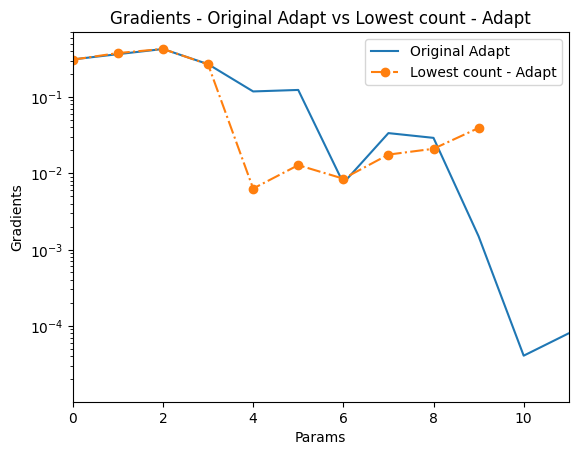

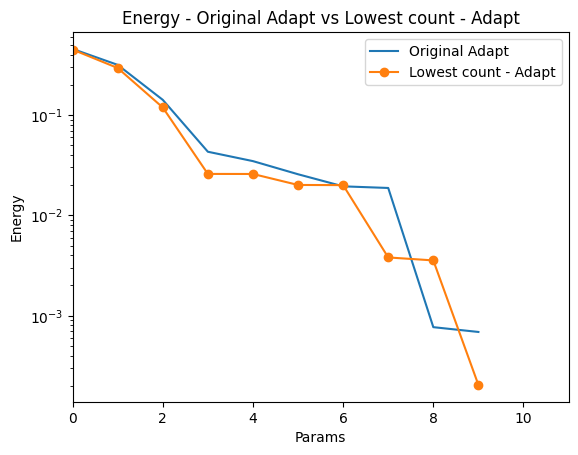

In [7]:
import numpy as np
grad = np.array(grad)

G_Exact = (0.3100451588582116 , 0.36333417728273754, 0.4247574417703076, 0.2689421354231678, 0.11800197933700611, 0.12345368822802208,
            0.007420281812857612, 0.03354563739855884 , 0.029061752158627868, 0.0014907673809587962, 4.058027986704677e-05, 7.976896690634755e-05,
            5.913441683514514e-05, 0.00011328401551519846, 1.989246929409716e-05, 3.843530082175278e-05,  0.0017755760879906296, 0.0009282356568736209,
             2.0769533991756538e-05, 2.0776790979757515e-05,1.678514206528755e-05)

E_Exact = np.array([-1.430083652442, -1.569460375668, -1.743633446894,-1.842110157560,
                     -1.850435938949, -1.859460023915,  -1.865676740601, -1.866387973815, 
                       -1.884356032844,-1.884436165205 ])

Error_OAdapt = np.array(E_Exact - FCI)
Error_NAdapt = np.array(energies - FCI)

GP = np.arange(0,21, 1.0)
Grad_distance = np.arange(0, 10, 1.0)

import matplotlib.pyplot as plt
plt.plot(GP, G_Exact, '-', label = 'Original Adapt')
plt.plot(Grad_distance, grad, '-.o', label = 'Lowest count - Adapt')
plt.legend()
plt.yscale('log')
plt.xlim(0,11)
plt.xlabel ('Params')
plt.ylabel('Gradients')
plt.title('Gradients - Original Adapt vs Lowest count - Adapt')
plt.show()


plt.plot(Grad_distance, Error_OAdapt, '-', label = 'Original Adapt') 
plt.plot(Grad_distance, Error_NAdapt, '-o', label = 'Lowest count - Adapt') 
plt.legend()
plt.xlim(0,11)
plt.xlabel ('Params')
plt.ylabel('Energy')
plt.yscale('log')
plt.title('Energy - Original Adapt vs Lowest count - Adapt')
plt.show()

## Started with 5Adapt parameters

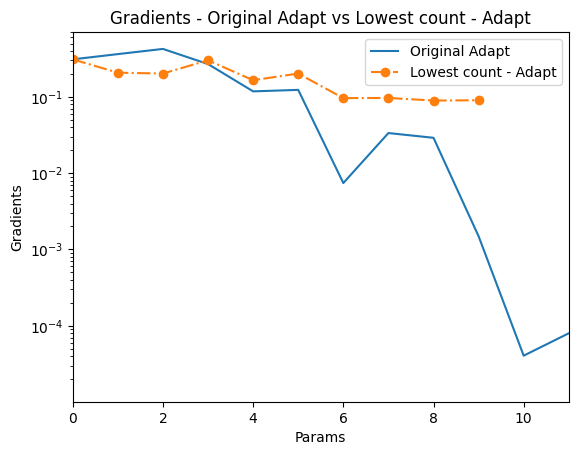

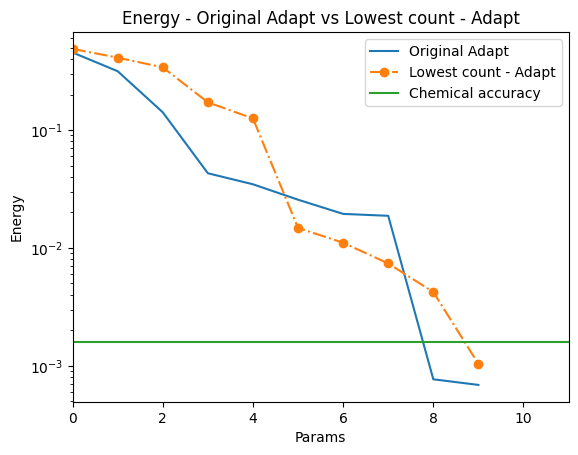

In [10]:
import numpy as np


G_Exact = (0.3100451588582116 , 0.36333417728273754, 0.4247574417703076, 0.2689421354231678, 0.11800197933700611, 0.12345368822802208,
            0.007420281812857612, 0.03354563739855884 , 0.029061752158627868, 0.0014907673809587962, 4.058027986704677e-05, 7.976896690634755e-05,
            5.913441683514514e-05, 0.00011328401551519846, 1.989246929409716e-05, 3.843530082175278e-05,  0.0017755760879906296, 0.0009282356568736209,
             2.0769533991756538e-05, 2.0776790979757515e-05,1.678514206528755e-05)

E_Exact = np.array([-1.430083652442, -1.569460375668, -1.743633446894,-1.842110157560,
                     -1.850435938949, -1.859460023915,  -1.865676740601, -1.866387973815, 
                       -1.884356032844,-1.884436165205 ])

Error_OAdapt = np.array(E_Exact - FCI)
Error_NAdapt = np.array(energies_5P - FCI)

GP = np.arange(0,21, 1.0)
Grad_distance = np.arange(0, 10, 1.0)
chem_accuracy = np.full(21, 1.59e-3)

import matplotlib.pyplot as plt
plt.plot(GP, G_Exact, '-', label = 'Original Adapt')
plt.plot(Grad_distance, grad_5P, '-.o', label = 'Lowest count - Adapt')
plt.legend()
plt.yscale('log')
plt.xlim(0,11)
plt.xlabel ('Params')
plt.ylabel('Gradients')
plt.title('Gradients - Original Adapt vs Lowest count - Adapt')
plt.show()


plt.plot(Grad_distance, Error_OAdapt, '-', label = 'Original Adapt') 
plt.plot(Grad_distance, Error_NAdapt, '-.o', label = 'Lowest count - Adapt') 
plt.plot(GP, chem_accuracy, '-', label = 'Chemical accuracy') 
plt.legend()
plt.xlim(0,11)
plt.xlabel ('Params')
plt.ylabel('Energy')
plt.yscale('log')
plt.title('Energy - Original Adapt vs Lowest count - Adapt')
plt.show()